In [43]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import matplotlib as mpl
from matplotlib import cm

## Fock State Probability Distributions

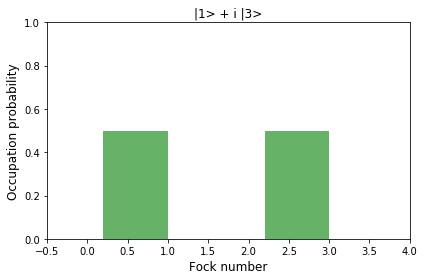

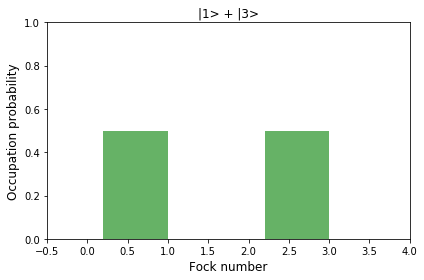

In [2]:
# the fock state probability distribution for our target state (fig 2d)
target = (fock(4,1) + 1j*fock(4,3)).unit()
target2 = (fock(4,1) + fock(4,3)).unit()

fig, axes = plt.subplots(1, 1, figsize=(6,4))
plot_fock_distribution(target, fig=fig, ax=axes, title="|1> + i |3>");
fig.tight_layout()
plt.show()
fig, axes = plt.subplots(1, 1, figsize=(6,4))
plot_fock_distribution(target2, fig=fig, ax=axes, title="|1> + |3>"); 
fig.tight_layout()
plt.show()

## Wigner Functions

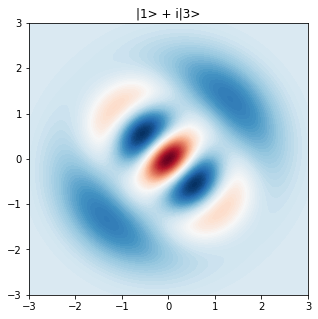

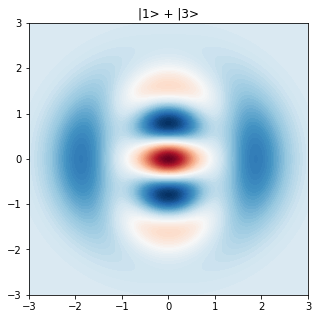

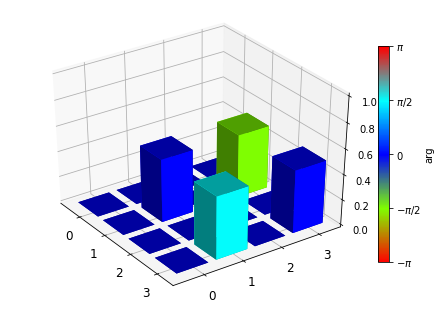

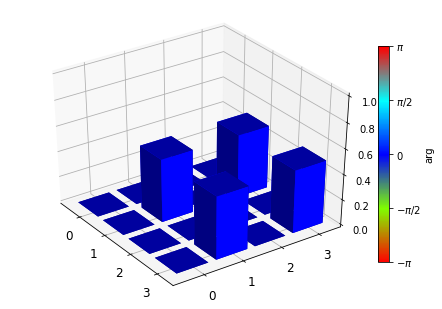

In [3]:
# now we're talking
xvec = np.linspace(-3,3,200)
W_target = wigner(target, xvec, xvec)
W_target2 = wigner(target2, xvec, xvec)
rho_target = ket2dm(target)
rho_target2 = ket2dm(target2)

# real deal plots
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
cont0 = axes.contourf(xvec, xvec, W_target, 100, cmap=cm.RdBu)
lbl0 = axes.set_title("|1> + i|3>")
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
cont1 = axes.contourf(xvec, xvec, W_target2, 100, cmap=cm.RdBu)
lbl1 = axes.set_title("|1> + |3>")
# plt.tight_layout()
plt.show()

# density matrix histograms
matrix_histogram_complex(rho_target)
matrix_histogram_complex(rho_target2)
plt.show()

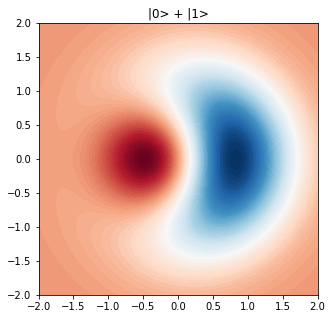

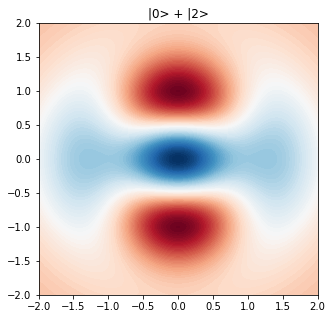

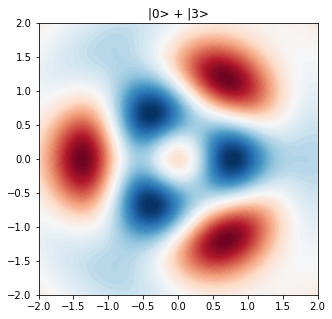

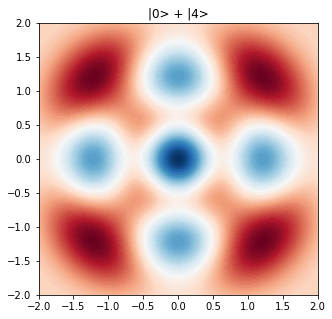

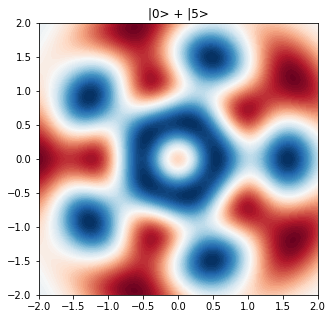

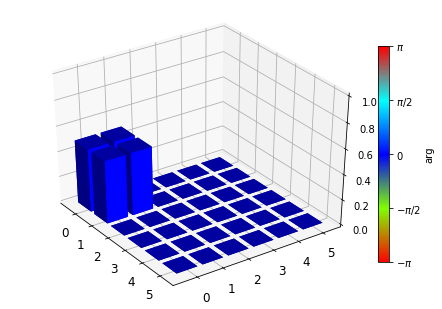

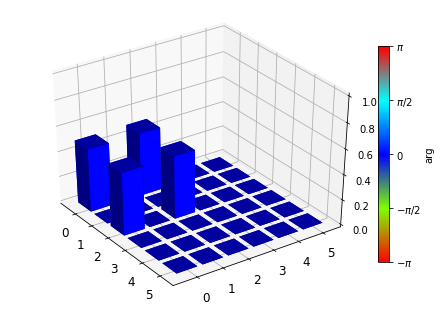

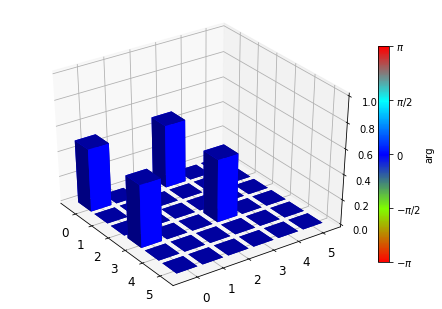

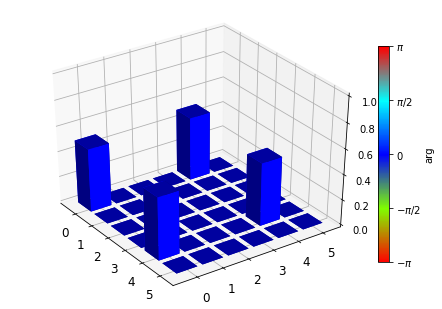

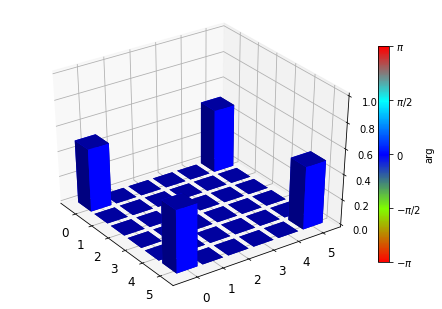

In [4]:
# figure 3 of Hofheinz et al
xvec = np.linspace(-2,2,200)
rho_fig3 = [] # density matrices
W_fig3 = [] # wigner functions
cont = [] # contours
for m in range(5):
    ket = (fock(6,0)+fock(6,m+1)).unit()
    rho_fig3.append(ket2dm(ket))
    W_fig3.append(wigner(ket, xvec, xvec))
    cont.append(0) # placeholder

# fig, axes = plt.subplots(1, 5, figsize=(18,3))
for m in range(5):
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.contourf(xvec, xvec, W_fig3[m], 100, cmap=cm.RdBu)
    axes.set_title("|0> + |%d>" % (m+1))
plt.show()

# density matrices
# for m in range(5):
#     fig, axes = plt.subplots(1,1, figsize=(5,5))
#     hinton(rho_fig3[m], ax=axes)
# plt.show()

for m in range(5):
    matrix_histogram_complex(rho_fig3[m])
plt.show()


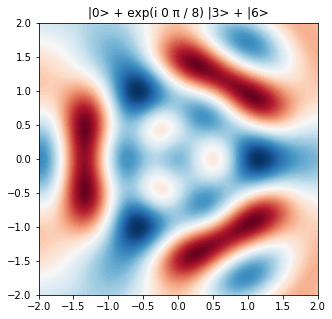

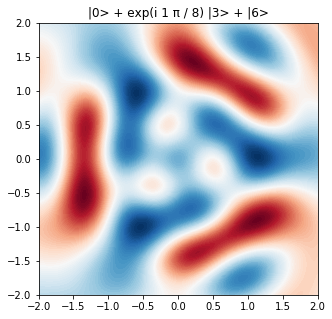

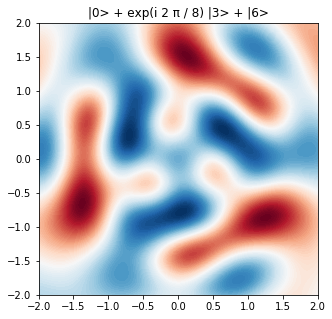

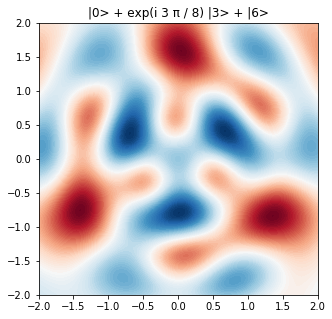

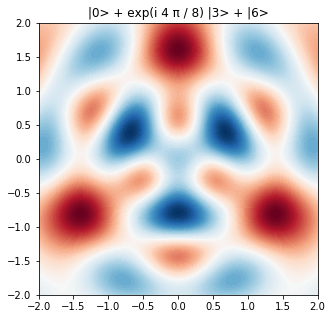

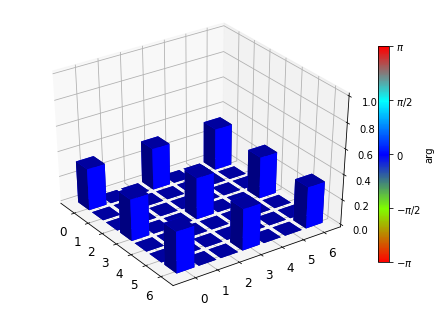

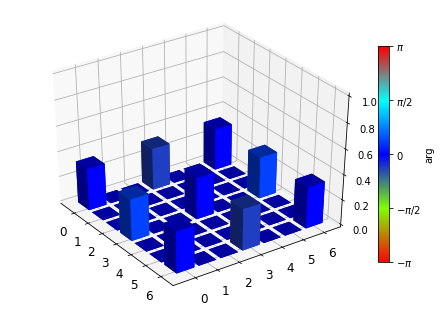

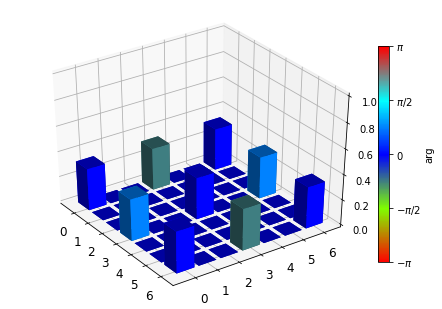

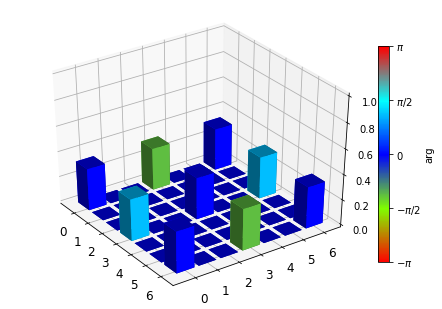

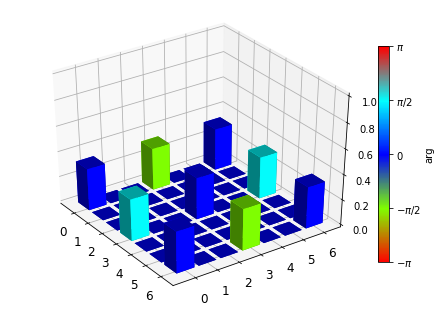

In [5]:
# figure 4 of Hofheinz et al
xvec = np.linspace(-2,2,200)
W_fig4 = [] # wigner functions
rho_fig4 = [] # density matrices

for k in range(5):
    ket = (fock(7, 0) + np.exp(1j * k * np.pi / 8) * fock(7, 3) + fock(7, 6)).unit()
    W_fig4.append(wigner(ket, xvec, xvec))
    rho_fig4.append(ket2dm(ket))

# fig, axes = plt.subplots(1, 5, figsize=(18,3))
for m in range(5):
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.contourf(xvec, xvec, W_fig4[m], 100, cmap=cm.RdBu)
    axes.set_title("|0> + exp(i %d π / 8) |3> + |6>" % (m))
plt.show()

# BUGGY - doesn't show phase
for m in range(5):
#     fig, axes = plt.subplots(1,1, figsize=(5,5))
#     hinton(rho_fig4[m], ax=axes)
    matrix_histogram_complex(rho_fig4[m])
plt.show()

## Time Dependent Simulations - Attempt #1

In [6]:
# Time dependent JC simulation of synthesis sequence
doff = 2 * np.pi * (-463)    # MHz; off-resonance detuning
wr = 2 * np.pi * 6570        # MHz; resonator frequency
# wq = wr + doff               # qubit frequency
omq = 1000                   # MHz/2pi; qubit drive strength
om = 2 * np.pi * 19          # MHz; coupling strength
N = 10                       # number of cavity fock states

# states
ground = basis(2, 1)
excited = basis(2, 0)
vac = fock(N, 0)
one = fock(N, 1)
two = fock(N, 2)
three = fock(N, 3)

# intial state = |1> + i|3>
target = tensor(ground, (one + 1j*three).unit())

# operators
a = tensor(qeye(2), destroy(N))
sm = tensor(sigmam(), qeye(N))
sz = tensor(sigmaz(), qeye(N))

# hamiltonian
H_swap = 0.5 * om * (sm * a.dag() + sm.dag() * a)         # on-resonance swap
H_phase = doff * sm.dag() * sm           # off-resonance phase shift (original)
# H_phase = 0.5 * doff * sz                # off-resonance phase shift (sigmaz only)
H_qudrive = 0.5 * omq * (sm.dag() + sm)  # off-resonance qubit drive

opts = Options(store_final_state=True) # options for M.E. solver

In [8]:
# perform first round swap
# ***how to run hamiltonian backwards in time?
H = H_swap
t1 = np.pi / (om * np.sqrt(3)) # swap time t1
times_t1 = np.linspace(0, t1, 100)
result_t1 = mesolve(H, target, times_t1, [], [sm.dag()*sm, a.dag()*a], options=opts)
psi_t1 = result_t1.final_state

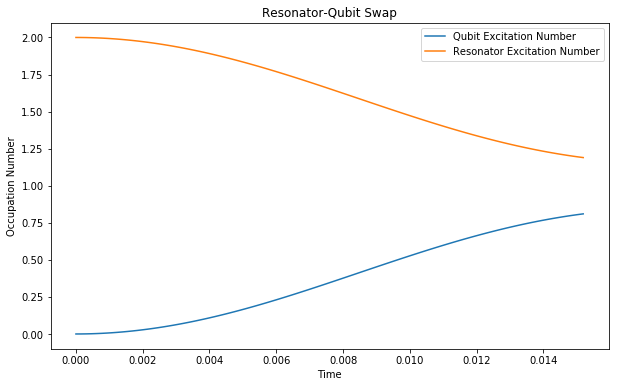

In [9]:
# plot first round swap
nq_t1 = result_t1.expect[0]
nr_t1 = result_t1.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(times_t1, nq_t1, label="Qubit Excitation Number")
axes.plot(times_t1, nr_t1, label="Resonator Excitation Number")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation Number')
axes.set_title('Resonator-Qubit Swap')
plt.show()

In [ ]:
# get state projections after first swap
g1 = tensor(ground, one).dag() * psi_t1 # <g, 1|ψ(t1)>
e0 = tensor(excited, vac).dag() * psi_t1 # <e, 0|ψ(t1)>
e2 = tensor(excited, two).dag() * psi_t1 # <e, 2|ψ(t1)>
print('g1:', g1,'\ne0:', e0,'\ne2:', e2)

In [ ]:
# do phase rotation
H = H_phase
t2 = np.pi / np.abs(omq)
times_t2 = np.linspace(t1, t1+t2, 100)
result_t2 = mesolve(H, psi_t1, times_t2, [], [sm.dag()*sm, a.dag()*a], options=opts)
psi_t2 = result_t2.final_state

In [ ]:
# plot result
nq_t2 = result_t2.expect[0]
nr_t2 = result_t2.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(times_t2, nq_t2, label="Phase: Qubit Excitation Number")
axes.plot(times_t2, nr_t2, label="Phase: Resonator Excitation Number")
axes.plot(times_t1, nq_t1, label="Swap: Qubit Excitation Number")
axes.plot(times_t1, nr_t1, label="Swap: Resonator Excitation Number")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation Number')
axes.set_title('Qubit Phase Rotation')
plt.show()

In [ ]:
# get state projections after phase rotation
# BUGGY: the nonzero states are NOT what we expect
# these cofficients are all zero
e1 = tensor(excited, one).dag() * psi_t2 # <e, 1|ψ(t2)>
g0 = tensor(ground, vac).dag() * psi_t2 # <g, 0|ψ(t2)>
g2 = tensor(ground, two).dag() * psi_t2 # <g, 2|ψ(t2)>
print('e1:', e1,'\ng0:', g0,'\ng2:', g2)

# but these coefficients are similar to the values we calculated, but still off by a phase shift
e0 = tensor(excited, vac).dag() * psi_t2 # <e, 0|ψ(t2)>
e2 = tensor(excited, two).dag() * psi_t2 # <e, 2|ψ(t2)>
g1 = tensor(ground, one).dag() * psi_t2 # <g, 1|ψ(t2)>
print('e0:', e0,'\ne2:', e2,'\ng1:', g1)

In [ ]:
sigmam()*excited

In [ ]:
# use fidelity with partial trace to check final resonator state
# to project:
# define projection op |n><n|
# Tr(|n><n|ψ><ψ|)
# use expect(projection)
# for wigner functions, need partial trace to get resonator only
# forward order: pulse (+rotation), swap, rotate (doff only)

## Time Dependent Simulations - Attempt #2

In [157]:
# Time dependent JC simulation of synthesis sequence
doff = 2 * np.pi * (-463.0)    # MHz; off-resonance detuning
wr = 2 * np.pi * 6570.0        # MHz; resonator frequency
# wq = wr + doff               # qubit frequency
omq = 1000.0                   # MHz/2pi; qubit drive strength
om = 2 * np.pi * 19.0          # MHz; coupling strength
N = 10                       # number of cavity fock states
gamma = 0.000001             # atom dissipation rate

# states
ground = basis(2, 0)
excited = basis(2, 1)
vac = fock(N, 0)
one = fock(N, 1)
two = fock(N, 2)
three = fock(N, 3)

# define projection operators
# proj0 = tensor(qeye(2), vac).proj()
# proj1 = tensor(qeye(2), one).proj()
# proj2 = tensor(qeye(2), two).proj()
# proj3 = tensor(qeye(2), three).proj()
# proj0 = tensor(qeye(2), vac) * tensor(qeye(2), vac).dag()
# proj1 = tensor(qeye(2), one) * tensor(qeye(2), one).dag()
# proj2 = tensor(qeye(2), two) * tensor(qeye(2), two).dag()
# proj3 = tensor(qeye(2), three) * tensor(qeye(2), three).dag()
proj0 = tensor(qeye(2),basis(N,0))*(tensor(qeye(2),basis(N,0))).dag()
proj1 = tensor(qeye(2),basis(N,1))*(tensor(qeye(2),basis(N,1))).dag()
proj2 = tensor(qeye(2),basis(N,2))*(tensor(qeye(2),basis(N,2))).dag()
proj3 = tensor(qeye(2),basis(N,3))*(tensor(qeye(2),basis(N,3))).dag()


# proj1 = tensor(basis(N,1),qeye(2))*(tensor(basis(N,1),qeye(2))).dag()
# proj2 = tensor(basis(N,2),qeye(2))*(tensor(basis(N,2),qeye(2))).dag()
# proj3 = tensor(basis(N,3),qeye(2))*(tensor(basis(N,3),qeye(2))).dag()
# proj4 = tensor(basis(N,4),qeye(2))*(tensor(basis(N,4),qeye(2))).dag()

# projg = tensor(ground, qeye(N)).proj()
# proje = tensor(excited, qeye(N)).proj()
projg = tensor(ground, qeye(N)) * tensor(ground, qeye(N)).dag()
proje = tensor(excited, qeye(N)) * tensor(excited, qeye(N)).dag()

# target state = |g>(|1> + i|3>)
target = tensor(ground, (one + 1j*three).unit())
# initial state = |g>|0>
psi0 = tensor((-0.286895130017 + 0.248709156436*1j)*ground, vac)
psi0 = tensor(ground, vac)
psi0 = psi0.unit()

# operators
a = tensor(qeye(2), destroy(N))
sm = tensor(destroy(2), qeye(N))
sz = tensor(sigmaz(), qeye(N))

# options for M.E. solver
opts = Options(store_final_state=True) 

# times (from check-calculations.ipynb)
t_op = [0.0031415926535897933, 0.01642025261264906, 0.003681549457045517, 0.0031415926535897933, 0.01206609876842327, 0.003681549457045517, 0.0031415926535897933, 0.0151934281365691]
t_op = np.cumsum(t_op) # convert from time intervals to absolute times
print('times:', t_op)


# collapse operators (needed to make solver work with TD ham)
c_ops = []
rate = gamma
c_ops.append(np.sqrt(rate) * sm)

# print(sm)

times: [0.00314159 0.01956185 0.02324339 0.02638499 0.03845109 0.04213264
 0.04527423 0.06046766]


In [158]:
# intermediate states for checking TD ham progression
psi_t = []

# ψ(0)
psi_t.append((-0.28689 + 1j*0.2487091) * tensor(ground, vac))
# ψ(t1)
psi_t.append((-0.31944 - 1j*0.2052) * tensor(excited, vac))
# ψ(t2)
psi_t.append((0.4489 + 1j*0.6987) * tensor(ground, one) + (0.4685 + 1j*0.30102) * tensor(excited, vac))
# ψ(t3)
psi_t.append((-0.4489 + 1j*0.6987) * tensor(ground, one) + (0.15686 - 1j*0.5343) * tensor(excited, vac))
# ψ(t4)
psi_t.append((-0.7969 - 1j*0.23393) * tensor(excited, one) + (0.534368 + 1j*0.156861) * tensor(ground, vac))
# ψ(t5)
psi_t.append((-0.4180 - 1j*0.1227) * tensor(excited, one) - (0.1568 - 1j*0.5343) * tensor(ground, vac) - (0.1991 - 1j*0.6784) * tensor(ground, two))
# ψ(t6)
psi_t.append((1j*0.43571) * tensor(excited, one) - (0.1568 - 1j*0.5343) * tensor(ground, vac) + (0.1991 - 1j*0.6784) * tensor(ground, two))
# ψ(t7)
psi_t.append((0.43571) * tensor(ground, one) + 1j*0.556 * tensor(excited, vac) - 0.7071 * tensor(excited, two))
# ψ(t8)
psi_t.append(target)
# normalize
psi_t = [psi.unit() for psi in psi_t]

In [169]:
# -------------- THIS IS THE REAL ONE ---------------

# define the Hamiltonian
H0 = 0.5 * om * (sm * a.dag() + sm.dag() * a) # JC interaction on-resonance
Hoff = doff * sm.dag() * sm # phase rotation off-resonance
eye = tensor(qeye(2), qeye(N))
sp = sm.dag()

args = {'H0': H0, 'Hoff': Hoff, 'sm': sm, 'sp': sp, 'a': a, 'omq': omq, 'om': om, 'doff': doff, 'eye': eye}
def H_t(t, args):
    H0 = args['H0']
    eye = args['eye']
    Hoff = args['Hoff']
    sm = args['sm']
    sp = args['sp']
#     a = args['a']
    omq = args['omq']
    
    if t < t_op[0]: # pulse
        return H0 + Hoff + 0.5 * omq * (sp * np.exp(-1j*doff*t) + sm * np.exp(+1j*doff*t))
    elif t < t_op[1]: # swap
        return H0
    elif t < t_op[2]: # rotate
        return H0 + Hoff
    elif t < t_op[3]: # pulse
        return H0 + Hoff + 0.5 * omq * (sp * np.exp(-1j*doff*t) + sm * np.exp(+1j*doff*t))
    elif t < t_op[4]: # swap
        return H0
    elif t < t_op[5]: # rotate
        return H0 + Hoff
    elif t < t_op[6]: # pulse
        return H0 + Hoff + 0.5 * omq * (sp * np.exp(-1j*doff*t) + sm * np.exp(+1j*doff*t))
    elif t < t_op[7]: # swap
        return H0
    else: # leave it off resonance
        return H0 + Hoff

# tlist = np.linspace(0, 2*t_op[-1], 1000)

m = 6
tlist = np.linspace(0, t_op[m], 1000)

output = mesolve(H_t, psi0, tlist, c_ops, [], args=args)

# H = 0.5 * omq * (sm.dag() + sm) debugging
# output = mesolve(H, psi0, tlist, c_ops, [], args=args, options=opts)

states = output.states
psif = states[-1]

In [329]:
# -------------- THIS IS THE DEBUGGING ONE ---------------

t_op = [0.0, 0.0031415926535897933, 0.01642025261264906, 0.003681549457045517, 0.0031415926535897933, 0.01206609876842327, 0.003681549457045517, 0.0031415926535897933, 0.0151934281365691]
t_op = np.cumsum(t_op) # convert from time intervals to absolute times
print('times:', t_op)

# define the Hamiltonian
H0 = 0.5 * om * (sm * a.dag() + sm.dag() * a) # JC interaction on-resonance
Hoff = doff * sm.dag() * sm # phase rotation off-resonance
eye = tensor(qeye(2), qeye(N))
sp = sm.dag()

args = {'H0': H0, 'Hoff': Hoff, 'sm': sm, 'sp': sp, 'omq': omq, 'om': om, 'doff': doff, 'eye': eye}
def H_t(t, args):
    H0 = args['H0']
    eye = args['eye']
    Hoff = args['Hoff']
    sm = args['sm']
    sp = args['sp']
    omq = args['omq']
    
    if t < t_op[1]: # pulse
        return H0 + Hoff + 0.5 * omq * (sp * np.exp(-1j*doff*t) + sm * np.exp(+1j*doff*t))
    elif t < t_op[2]: # swap
        return H0
    elif t < t_op[3]: # rotate
        return H0 + Hoff
    elif t < t_op[4]: # pulse
        return H0 + Hoff + 0.5 * omq * (sp * np.exp(-1j*doff*t) + sm * np.exp(+1j*doff*t))
    elif t < t_op[5]: # swap
        return H0
    elif t < t_op[6]: # rotate
        return H0 + Hoff
    elif t < t_op[7]: # pulse
        return H0 + Hoff + 0.5 * omq * (sp * np.exp(-1j*doff*t) + sm * np.exp(+1j*doff*t))
    elif t < t_op[8]: # swap
        return H0
    else: # leave it off resonance
        return H0 + Hoff

# tlist = np.linspace(0, 2*t_op[-1], 1000)

m = 7
tlist = np.linspace(t_op[m], t_op[m+1], 1000)
psi0 = psi_t[m]

output = mesolve(H_t, psi0, tlist, c_ops, [], args=args)

# H = 0.5 * omq * (sm.dag() + sm) debugging
# output = mesolve(H, psi0, tlist, c_ops, [], args=args, options=opts)

states = output.states
psif = states[-1]

times: [0.         0.00314159 0.01956185 0.02324339 0.02638499 0.03845109
 0.04213264 0.04527423 0.06046766]


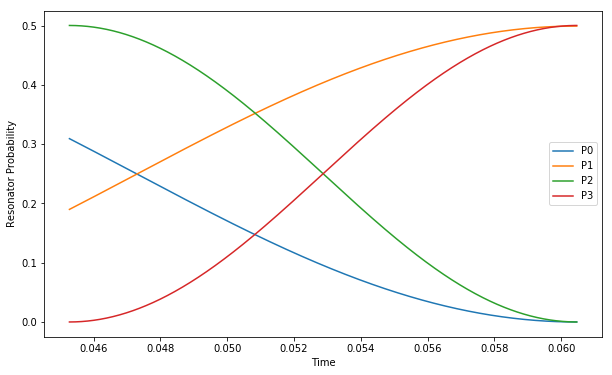

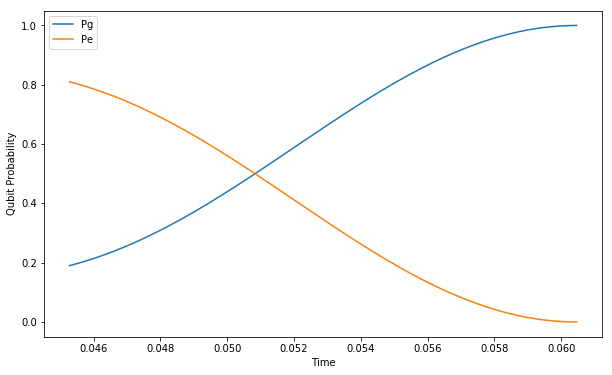

In [330]:
# define projection expectations

# states = [psi.unit() for psi in states]
p0 = expect(proj0, states)
p1 = expect(proj1, states)
p2 = expect(proj2, states)
p3 = expect(proj3, states)

pg = expect(projg, states)
pe = expect(proje, states)

# plot results
fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, p0, label="P0")
axes.plot(tlist, p1, label="P1")
axes.plot(tlist, p2, label="P2")
axes.plot(tlist, p3, label="P3")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Resonator Probability')
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, pg, label="Pg")
axes.plot(tlist, pe, label="Pe")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Qubit Probability')
plt.show()

# UNCOMMENT BELOW WHEN FULL SIMULATION IS VERIFIED

# # wigner functions
# xvec = np.linspace(-5,5,200)
# psif_res = psif.ptrace(1)
# target_res = target.ptrace(1)

# fig, axes = plt.subplots(1, 1, figsize=(5,5))
# axes.contourf(xvec, xvec, wigner(psif_res, xvec, xvec), 100, cmap=cm.RdBu)
# axes.set_title("Final state wigner function")
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(5,5))
# axes.contourf(xvec, xvec, wigner(target_res, xvec, xvec), 100, cmap=cm.RdBu)
# axes.set_title("Target state wigner function")
# plt.show()

# # fock state distributions
# fig, axes = plt.subplots(1, 1, figsize=(6,4))
# plot_fock_distribution(psif_res, fig=fig, ax=axes, title="Final State Distribution");
# fig.tight_layout()
# plt.show()
# fig, axes = plt.subplots(1, 1, figsize=(6,4))
# plot_fock_distribution(target_res, fig=fig, ax=axes, title="Target State Distribution"); 
# fig.tight_layout()
# plt.show()


initial t = t 7
final t = t 8


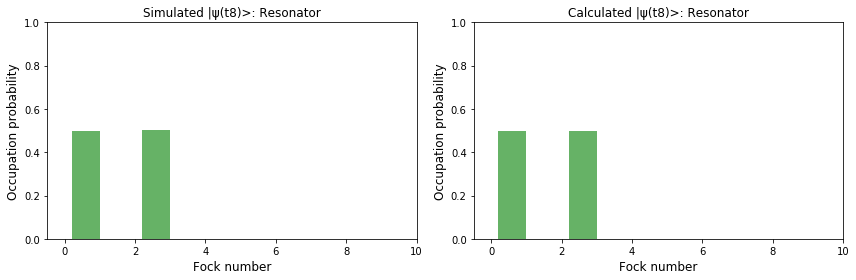

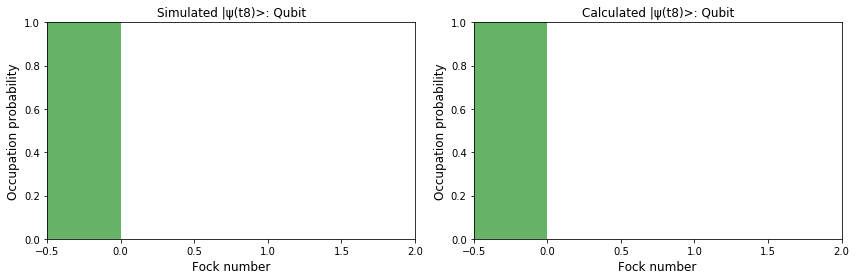

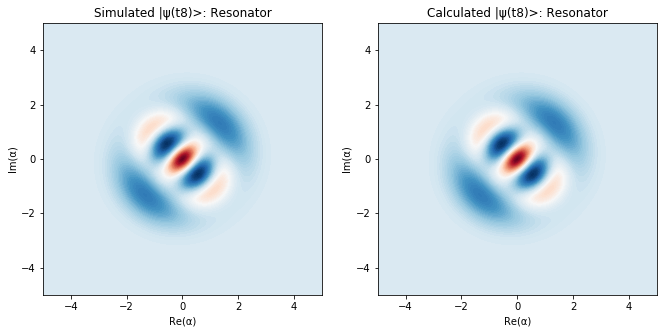

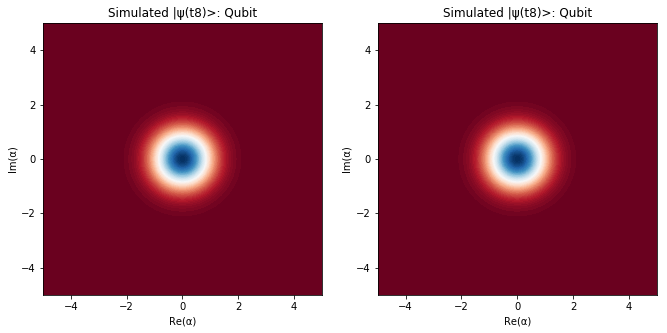

In [331]:
curr_state = psi_t[m+1] # current intermediate state output from simulation
print('initial t = t', (m))
print('final t = t', (m+1))

xvec = np.linspace(-5,5,200)

psif_res = psif.ptrace(1)
psif_qu = psif.ptrace(0)
curr_res = curr_state.ptrace(1)
curr_qu = curr_state.ptrace(0)

# basis state distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_fock_distribution(psif_res, fig=fig, ax=axes[0], title="Simulated |ψ(t%d)>: Resonator" % (m+1));
plot_fock_distribution(curr_res, fig=fig, ax=axes[1], title="Calculated |ψ(t%d)>: Resonator" % (m+1));
fig.tight_layout()
filename = str('probability-figures/t%d-resonator.png' % (m+1))
plt.savefig(filename)
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_fock_distribution(psif_qu, fig=fig, ax=axes[0], title="Simulated |ψ(t%d)>: Qubit" % (m+1));
plot_fock_distribution(curr_qu, fig=fig, ax=axes[1], title="Calculated |ψ(t%d)>: Qubit" % (m+1)); 
fig.tight_layout()
filename = str('probability-figures/t%d-qubit.png' % (m+1))
plt.savefig(filename)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].contourf(xvec, xvec, wigner(psif_res, xvec, xvec), 100, cmap=cm.RdBu)
axes[0].set_title("Simulated |ψ(t%d)>: Resonator" % (m+1))
axes[1].contourf(xvec, xvec, wigner(curr_res, xvec, xvec), 100, cmap=cm.RdBu)
axes[1].set_title("Calculated |ψ(t%d)>: Resonator" % (m+1))
axes[0].set_xlabel('Re(α)')
axes[0].set_ylabel('Im(α)')
axes[1].set_xlabel('Re(α)')
axes[1].set_ylabel('Im(α)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].contourf(xvec, xvec, wigner(psif_qu, xvec, xvec), 100, cmap=cm.RdBu)
axes[0].set_title("Simulated |ψ(t%d)>: Qubit" % (m+1))
axes[1].contourf(xvec, xvec, wigner(curr_qu, xvec, xvec), 100, cmap=cm.RdBu)
axes[1].set_title("Simulated |ψ(t%d)>: Qubit" % (m+1))
axes[0].set_xlabel('Re(α)')
axes[0].set_ylabel('Im(α)')
axes[1].set_xlabel('Re(α)')
axes[1].set_ylabel('Im(α)')
plt.show()

# --------------------------
# initial state

# psi0_res = psi0.ptrace(1)
# psi0_qu = psi0.ptrace(0)

# # basis state distributions
# fig, axes = plt.subplots(1, 2, figsize=(12,4))
# plot_fock_distribution(psi0_res, fig=fig, ax=axes[0], title="Simulated |ψ(t%d)>: Resonator" % (0));
# plot_fock_distribution(psi0_res, fig=fig, ax=axes[1], title="Calculated |ψ(t%d)>: Resonator" % (0));
# fig.tight_layout()
# plt.show()
# fig, axes = plt.subplots(1, 2, figsize=(12,4))
# plot_fock_distribution(psi0_qu, fig=fig, ax=axes[0], title="Simulated |ψ(t%d)>: Qubit" % (0));
# plot_fock_distribution(psi0_qu, fig=fig, ax=axes[1], title="Calculated |ψ(t%d)>: Qubit" % (0)); 
# fig.tight_layout()

# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(11,5))
# axes[0].contourf(xvec, xvec, wigner(psif_res, xvec, xvec), 100, cmap=cm.RdBu)
# axes[0].set_title("Simulated |ψ(t%d)>: Resonator" % (0))
# axes[1].contourf(xvec, xvec, wigner(curr_res, xvec, xvec), 100, cmap=cm.RdBu)
# axes[1].set_title("Calculated |ψ(t%d)>: Resonator" % (0))
# axes[0].set_xlabel('Re(α)')
# axes[0].set_ylabel('Im(α)')
# axes[1].set_xlabel('Re(α)')
# axes[1].set_ylabel('Im(α)')
# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(11,5))
# axes[0].contourf(xvec, xvec, wigner(psif_qu, xvec, xvec), 100, cmap=cm.RdBu)
# axes[0].set_title("Simulated |ψ(t%d)>: Qubit" % (0))
# axes[1].contourf(xvec, xvec, wigner(curr_qu, xvec, xvec), 100, cmap=cm.RdBu)
# axes[1].set_title("Simulated |ψ(t%d)>: Qubit" % (0))
# axes[0].set_xlabel('Re(α)')
# axes[0].set_ylabel('Im(α)')
# axes[1].set_xlabel('Re(α)')
# axes[1].set_ylabel('Im(α)')
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(6,4))
# plot_fock_distribution(curr_res, fig=fig, ax=axes, title="Desired State: Resonator"); 
# fig.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(6,4))
# plot_fock_distribution(curr_qu, fig=fig, ax=axes, title="Desired State: Qubit"); 
# fig.tight_layout()
# plt.show()


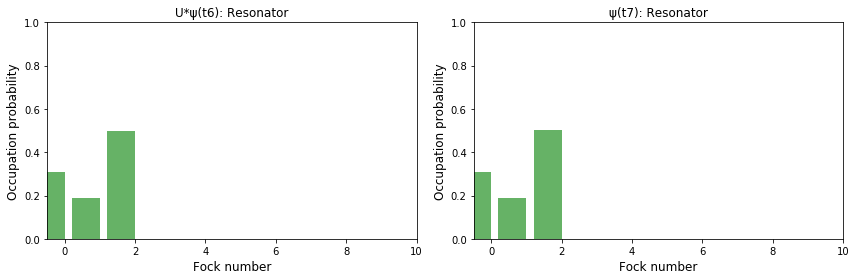

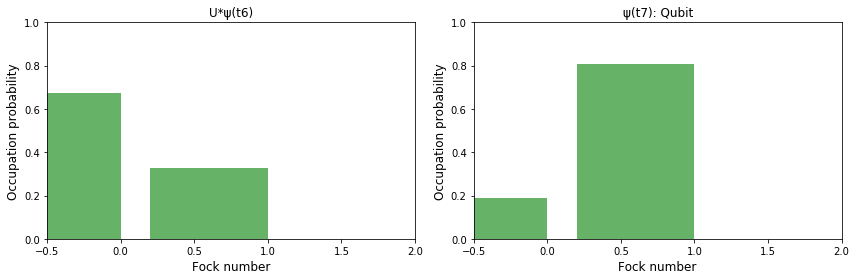

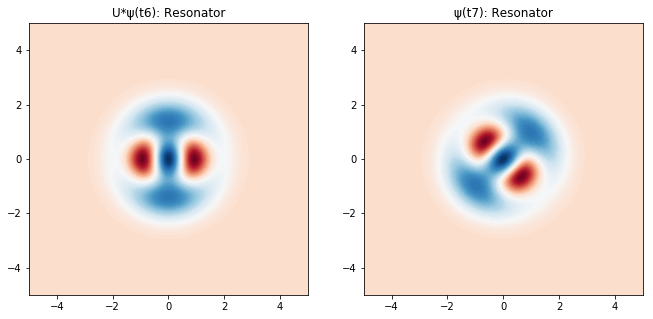

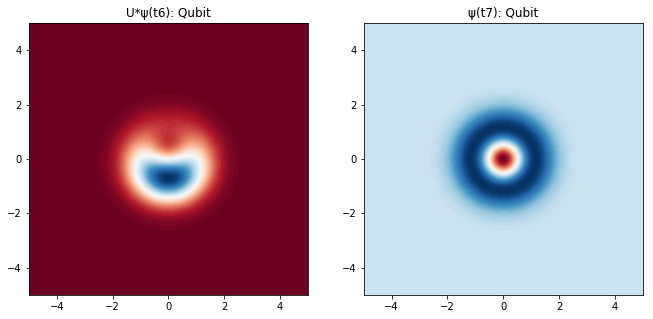

In [258]:
psi7 = psi_t[7]
psi6 = psi_t[6]

dt = t[7]-t[6]
# Hpulse = doff * sp * sm + 0.5 * omq * (sp * np.exp(-1j*doff*dt) + sm * np.exp(1j*doff*dt))
H1 = 0.5 * omq * (sp + sm)
H2 = doff * sp * sm
# U = (-1j*Hpulse*(t[7]-t[6])).expm()
U1 = (-1j*H1*dt).expm()
U2 = (-1j*H2*dt).expm()
# psi7exp = (U*psi6).unit()
psi7exp = U2 * U1 * psi6

xvec = np.linspace(-5,5,200)

psi7exp_res = psi7exp.ptrace(1)
psi7exp_qu = psi7exp.ptrace(0)
psi7_res = psi7.ptrace(1)
psi7_qu = psi7.ptrace(0)

# basis state distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_fock_distribution(psi7exp_res, fig=fig, ax=axes[0], title="U*ψ(t6): Resonator");
plot_fock_distribution(psi7_res, fig=fig, ax=axes[1], title="ψ(t7): Resonator");
fig.tight_layout()
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_fock_distribution(psi7exp_qu, fig=fig, ax=axes[0], title="U*ψ(t6)");
plot_fock_distribution(psi7_qu, fig=fig, ax=axes[1], title="ψ(t7): Qubit"); 
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].contourf(xvec, xvec, wigner(psi7exp_res, xvec, xvec), 100, cmap=cm.RdBu)
axes[0].set_title("U*ψ(t6): Resonator")
axes[1].contourf(xvec, xvec, wigner(psi7_res, xvec, xvec), 100, cmap=cm.RdBu)
axes[1].set_title("ψ(t7): Resonator")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].contourf(xvec, xvec, wigner(psi7exp_qu, xvec, xvec), 100, cmap=cm.RdBu)
axes[0].set_title("U*ψ(t6): Qubit")
axes[1].contourf(xvec, xvec, wigner(psi7_qu, xvec, xvec), 100, cmap=cm.RdBu)
axes[1].set_title("ψ(t7): Qubit")
plt.show()

In [259]:
t0 = 1
Htest = 0.5*qeye(2)
print(Htest)
Utest = (1j*Htest*t0).expm()
print(Utest)
Utest * basis(2, 0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0. ]
 [0.  0.5]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.87758256+0.47942554j 0.        +0.        j]
 [0.        +0.        j 0.87758256+0.47942554j]]


Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.87758256+0.47942554j]
 [0.        +0.        j]]

In [ ]:
sigmam()

In [ ]:
sigmap()

In [ ]:
about()

In [311]:
filename = str('probability-figures/t%d-resonator.png' % (m+1))
print(filename)

probability-figures/t2-resonator.png
